<a href="https://colab.research.google.com/github/andrewjohnlowe/CoreML/blob/main/CoreML_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Core ML "Anomaly" Detection

**Q: What is the objective of the homework? Anomaly detection or novelty detection?**

OK, given the nature of the data, I'm going to *assume* that the task is novelty detection, because it makes more sense that the purpose of gathering the measurements it to provide a means to diagnose heart problems when presented with a new patient. That is, we are interested in detecting whether a **new** observation is an outlier. We don't want to clean the dataset; we want to make predictions about new observations.

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Cardiotocography.csv")
df.shape

(16880, 23)

## EDA and data preparation

Let's take a look at the data. We don't seem to have any explicit missing values:

In [ ]:
# What kind of data do we have?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        16880 non-null  float64
 1   LB        16880 non-null  float64
 2   AC        16880 non-null  float64
 3   FM        16880 non-null  float64
 4   UC        16880 non-null  float64
 5   ASTV      16880 non-null  float64
 6   MSTV      16880 non-null  float64
 7   ALTV      16880 non-null  float64
 8   MLTV      16880 non-null  float64
 9   DL        16880 non-null  float64
 10  DS        16880 non-null  float64
 11  DP        16880 non-null  float64
 12  Width     16880 non-null  float64
 13  Min       16880 non-null  float64
 14  Max       16880 non-null  float64
 15  Nmax      16880 non-null  float64
 16  Nzeros    16880 non-null  float64
 17  Mode      16880 non-null  float64
 18  Mean      16880 non-null  float64
 19  Median    16880 non-null  float64
 20  Variance  16880 non-null  fl

In [ ]:
df.head()

id        LB        AC        FM        UC      ASTV      MSTV  \
0  1881.0  0.592593  0.000000  0.000000  0.294118  0.633803  0.338235   
1   421.0  0.574074  0.038462  0.000000  0.000000  0.816901  0.029412   
2    92.0  0.777778  0.000000  0.000000  0.000000  0.774648  0.029412   
3  1767.0  0.259259  0.000000  0.000000  0.294118  0.704225  0.191176   
4  1880.0  0.592593  0.000000  0.001773  0.294118  0.633803  0.352941   

       ALTV      MLTV        DL  ...       Min       Max      Nmax  Nzeros  \
0  0.000000  0.013807  0.500000  ...  0.045872  0.336207  0.333333     0.1   
1  0.527473  0.092702  0.000000  ...  0.770642  0.672414  0.166667     0.0   
2  0.736264  0.096647  0.000000  ...  0.816514  0.275862  0.222222     0.0   
3  0.000000  0.183432  0.428571  ...  0.174312  0.275862  0.222222     0.1   
4  0.000000  0.013807  0.428571  ...  0.045872  0.336207  0.333333     0.1   

       Mode      Mean    Median  Variance  Tendency  outlier  
0  0.485149  0.247423  0.284091  0.638418       1.0   b'yes'  
1  0.534653  0.587629  0.511364  0.016949       0.0   b'yes'  
2  0.633663  0.659794  0.602273  0.000000       1.0   b'yes'  
3  0.000000  0.164948  0.000000  0.361582       0.0   b'yes'  
4  0.485149  0.226804  0.272727  0.683616       1.0   b'yes'  

[5 rows x 23 columns]

I'll use pandas profiling to get a birds-eye view of the data and do some exploratory data analysis:

In [ ]:
! yes | pip uninstall pandas-profiling
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Found existing installation: pandas-profiling 3.2.0
Uninstalling pandas-profiling-3.2.0:
  Would remove:
    /usr/local/bin/pandas_profiling
    /usr/local/lib/python3.7/dist-packages/pandas_profiling-3.2.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas_profiling/*
Proceed (y/n)?   Successfully uninstalled pandas-profiling-3.2.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (21.9 MB)
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=261257 sha256=d1ecce93113db7fd57e6a4661ae244e620ab89c0d5fea63f6daa0163edfb5954
  Stored in directory: /tmp/pip-ephem-wheel-cache-iflamkwc/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
Successfully built pandas-profiling


In [ ]:
from pandas_profiling import ProfileReport

# Generate a profile report for the data:
profile = ProfileReport(
    df, 
    title = "Cardiotocography", 
    html = {"style": {"full_width": True}}
    )
profile.to_notebook_iframe()

*id* is just a label for each individual in the data and surely not an informative feature, so I'll discard that. *outlier* is the target variable. I'll recode it to match the typical encoding employed by **sklearn** for outlier detection: 1 for normal and -1 for anomalous.

In [ ]:
df.drop(columns="id", inplace = True)
df.replace(["b'no'", "b'yes'"], [1, -1], inplace = True)
df["outlier"].value_counts()

 1    16550
-1      330
Name: outlier, dtype: int64

In [ ]:
df.head()

LB        AC        FM        UC      ASTV      MSTV      ALTV  \
0  0.592593  0.000000  0.000000  0.294118  0.633803  0.338235  0.000000   
1  0.574074  0.038462  0.000000  0.000000  0.816901  0.029412  0.527473   
2  0.777778  0.000000  0.000000  0.000000  0.774648  0.029412  0.736264   
3  0.259259  0.000000  0.000000  0.294118  0.704225  0.191176  0.000000   
4  0.592593  0.000000  0.001773  0.294118  0.633803  0.352941  0.000000   

       MLTV        DL   DS  ...       Min       Max      Nmax  Nzeros  \
0  0.013807  0.500000  0.0  ...  0.045872  0.336207  0.333333     0.1   
1  0.092702  0.000000  0.0  ...  0.770642  0.672414  0.166667     0.0   
2  0.096647  0.000000  0.0  ...  0.816514  0.275862  0.222222     0.0   
3  0.183432  0.428571  0.0  ...  0.174312  0.275862  0.222222     0.1   
4  0.013807  0.428571  0.0  ...  0.045872  0.336207  0.333333     0.1   

       Mode      Mean    Median  Variance  Tendency  outlier  
0  0.485149  0.247423  0.284091  0.638418       1.0       -1  
1  0.534653  0.587629  0.511364  0.016949       0.0       -1  
2  0.633663  0.659794  0.602273  0.000000       1.0       -1  
3  0.000000  0.164948  0.000000  0.361582       0.0       -1  
4  0.485149  0.226804  0.272727  0.683616       1.0       -1  

[5 rows x 22 columns]

The data appears to already have been min-max scaled (by whom?):

In [ ]:
df.describe()

LB            AC            FM            UC          ASTV  \
count  16880.000000  16880.000000  16880.000000  16880.000000  16880.000000   
mean       0.483186      0.129270      0.011411      0.226668      0.425672   
std        0.175738      0.143077      0.060514      0.156665      0.216970   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.351852      0.000000      0.000000      0.117647      0.236111   
50%        0.481481      0.076923      0.000000      0.235294      0.408451   
75%        0.592593      0.192308      0.003546      0.304348      0.608108   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               MSTV          ALTV          MLTV            DL            DS  \
count  16880.000000  16880.000000  16880.000000  16880.000000  16880.000000   
mean       0.179521      0.064739      0.170819      0.113227      0.000770   
std        0.121198      0.146732      0.114551      0.171935      0.027742   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.088235      0.000000      0.094675      0.000000      0.000000   
50%        0.161765      0.000000      0.155819      0.000000      0.000000   
75%        0.220588      0.050633      0.226824      0.214286      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...           Min           Max          Nmax        Nzeros  \
count  ...  16880.000000  16880.000000  16880.000000  16880.000000   
mean   ...      0.379411      0.365604      0.230579      0.033365   
std    ...      0.252147      0.153285      0.159211      0.069209   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.155963      0.258621      0.111111      0.000000   
50%    ...      0.376147      0.353448      0.222222      0.000000   
75%    ...      0.596330      0.456897      0.333333      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

               Mode          Mean        Median      Variance      Tendency  \
count  16880.000000  16880.000000  16880.000000  16880.000000  16880.000000   
mean       0.563887      0.525497      0.475086      0.090984      0.670794   
std        0.128429      0.136375      0.146790      0.119737      0.295171   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.482143      0.431193      0.373494      0.015385      0.500000   
50%        0.567797      0.525773      0.478261      0.045198      0.500000   
75%        0.650000      0.621053      0.576087      0.122677      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            outlier  
count  16880.000000  
mean       0.960900  
std        0.276902  
min       -1.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  

[8 rows x 22 columns]

## Feature engineering

The homework says:
> Dataset description:
https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/semantic/Cardiotocography/Cardiotocography_22.html

This is **not** a description of the dataset! This is a report of the best paramaters for a range of different outlier detection algorithms. There is no description of the dataset provided.

I assumed that the dataset is likely one that I could find on the UCI Machine Learning Repository. I found what I believe to be the original dataset. The dataset description is here: https://archive.ics.uci.edu/ml/datasets/Cardiotocography

> ### Data Set Information:
>
> 2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified by three expert obstetricians and a consensus classification label assigned to each of them. Classification was both with respect to a morphologic pattern (A, B, C. ...) and to a fetal state (N, S, P). Therefore the dataset can be used either for 10-class or 3-class experiments.
>
> ### Attribute Information:
> 
> * LB - FHR baseline (beats per minute)
> * AC - # of accelerations per second
> * FM - # of fetal movements per second
> * UC - # of uterine contractions per second
> * DL - # of light decelerations per second
> * DS - # of severe decelerations per second
> * DP - # of prolongued decelerations per second
> * ASTV - percentage of time with abnormal short term variability
> * MSTV - mean value of short term variability
> * ALTV - percentage of time with abnormal long term variability
> * MLTV - mean value of long term variability
> * Width - width of FHR histogram
> * Min - minimum of FHR histogram
> * Max - Maximum of FHR histogram
> * Nmax - # of histogram peaks
> * Nzeros - # of histogram zeros
> * Mode - histogram mode
> * Mean - histogram mean
> * Median - histogram median
> * Variance - histogram variance
> * Tendency - histogram tendency
> * CLASS - FHR pattern class code (1 to 10)
> * NSP - fetal state class code (N=normal; S=suspect; P=pathologic)
> 
> 
> ### Relevant Papers:
> 
> Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318

I note that the target, *NSP* is multiclass, whereas the data provided for the homework does not contain this variable. Moreover, the latter data contains the target variable *outlier* that has only two values (yes and no) and an additional *id* variable. Therefore, I conclude that the person that created this homework task downloaded the former dataset, recoded and nenamed the target variable, and then wrote out the data to disk in a way that included the row indices.

Note the following line in the dataset description:

> The CTGs were also classified by three expert obstetricians and a consensus classification label assigned to each of them.

*That is, three domain experts who are familiar with this kind of data were involved in assigning the class labels. Therefore, it is not unreasonable to surmise that domain expertise was probably also employed in choosing features that are likely to be informative. Consequently, I'm inclined to believe that blindly combining features in the hope of finding more informative features would offer very little return. PCA and non-linear transforms may (or may not) be useful, but I trust that the raw features have been chosen to maximise utility. After all, if they were not worth measuring, why measure them?*

I also note that there are more observations in the dataset than cases in the original dataset. Maybe the dataset have been oversampled to inflate the number of observations? 

*This is not the raw data that was collected. This data has been manipulated and I don't know what was done to the data before I got it. Therefore, this data would be of very little use in a real clinical setting because we have no way of reproducing what happened to the data after it was collected!*

Let's plot a scatter plot matrix to see if we can see any evidence for correlations or dependency; this might indicate if the problem might be amenable to PCA or ICA.

In [ ]:
# from matplotlib import pyplot as plt
# import seaborn as sns
# sns.set(rc = {'figure.figsize':(20, 12)}) # Embiggen!

# # This is REALLY SLOW:
# sns.pairplot(
#     df.sample(frac = 0.1), 
#     kind="scatter", diag_kind="hist", hue="outlier")
# plt.show()

Plotting a scatter plot matrix with Seaborn is really slow. 

**Q: Is there a recommended faster method for plotting scatter plot matrices?**

Let's try Panda's native function for plotting them (I downsampled the data for faster plotting):

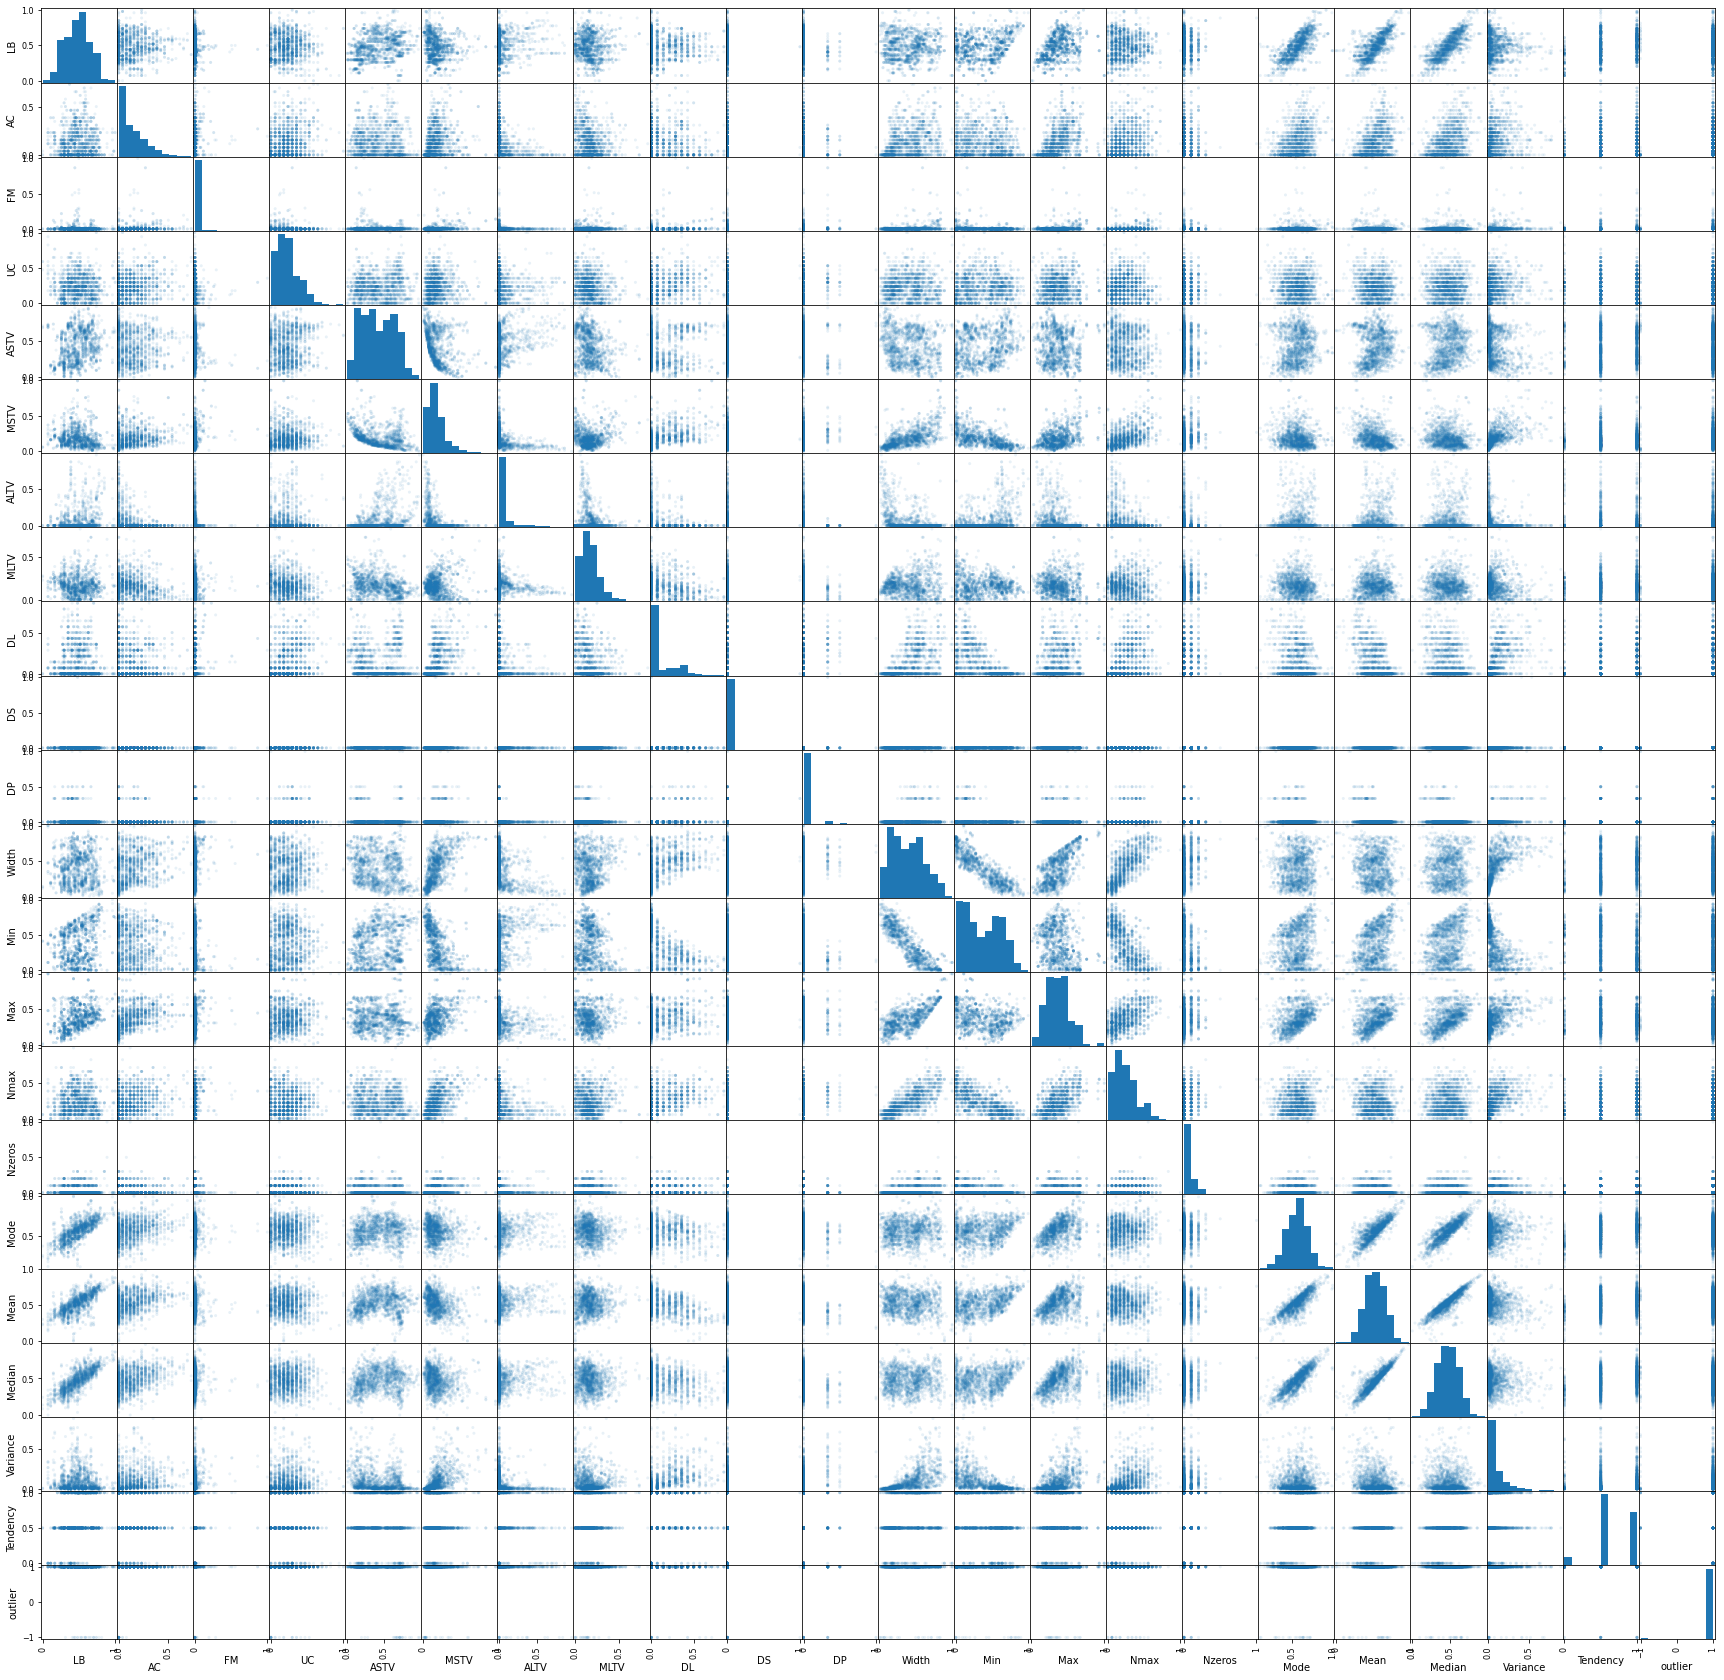

In [ ]:
from pandas.plotting import scatter_matrix
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

scatter_matrix(df.sample(frac = 0.1), alpha = 0.1, figsize = (30, 30), diagonal = 'hist');

This is a lot faster! But still quite slow. Some of the features have skewed distributions; perhaps it might be beneficial to apply a power transform. Also, some features are strongly correlated; perhaps PCA or ICA might be useful. I'm going to try splitting the data into normal and anomalous observations and fit a power transform on the just the normal observations and predict on all the observations (including those labelled as outliers). I'm doing this because I've been given the training labels, so it seems reasonable to learn the parameters of the power transforms without the anomalous cases present, so that those parameters are not affected by their presence. Hopefully, when those parameters are used to transform *all* the data, the outliers will stick out like a sore thumb.

**Q: What is an appropriate ordering of transformations? Power transform first, or scaling?**

The equivalent transformation pipeline in R, implemented in the `preProcess` function in the **caret** machine learning library, uses the following ordering (according to the help pages):

> The operations are applied in this order: zero-variance filter, near-zero variance filter, correlation filter, Box-Cox/Yeo-Johnson/exponential transformation, centering, scaling, range, imputation, PCA, ICA then spatial sign.

I assume there is some rationale for this choice and have therefore used the same ordering.

In [ ]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display='diagram')

pt = PowerTransformer(standardize = True)
scaler = StandardScaler()
pca = PCA()
ica = FastICA()

trans = make_pipeline(pt, scaler, pca)
trans

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA())])

In [ ]:
df.head()

LB        AC        FM        UC      ASTV      MSTV      ALTV  \
0  0.592593  0.000000  0.000000  0.294118  0.633803  0.338235  0.000000   
1  0.574074  0.038462  0.000000  0.000000  0.816901  0.029412  0.527473   
2  0.777778  0.000000  0.000000  0.000000  0.774648  0.029412  0.736264   
3  0.259259  0.000000  0.000000  0.294118  0.704225  0.191176  0.000000   
4  0.592593  0.000000  0.001773  0.294118  0.633803  0.352941  0.000000   

       MLTV        DL   DS  ...       Min       Max      Nmax  Nzeros  \
0  0.013807  0.500000  0.0  ...  0.045872  0.336207  0.333333     0.1   
1  0.092702  0.000000  0.0  ...  0.770642  0.672414  0.166667     0.0   
2  0.096647  0.000000  0.0  ...  0.816514  0.275862  0.222222     0.0   
3  0.183432  0.428571  0.0  ...  0.174312  0.275862  0.222222     0.1   
4  0.013807  0.428571  0.0  ...  0.045872  0.336207  0.333333     0.1   

       Mode      Mean    Median  Variance  Tendency  outlier  
0  0.485149  0.247423  0.284091  0.638418       1.0       -1  
1  0.534653  0.587629  0.511364  0.016949       0.0       -1  
2  0.633663  0.659794  0.602273  0.000000       1.0       -1  
3  0.000000  0.164948  0.000000  0.361582       0.0       -1  
4  0.485149  0.226804  0.272727  0.683616       1.0       -1  

[5 rows x 22 columns]

Fit the parameters to the data and then apply the transformations:

In [ ]:
y = df["outlier"]
df_normal, df_anomalous = df[df["outlier"] == 1].drop(columns = "outlier").copy(), df[df["outlier"] == -1].drop(columns = "outlier").copy()
trans.fit(df_normal)
df_trans = trans.transform(df.drop(columns = "outlier"))
df_trans = pd.DataFrame(df_trans, columns = df_normal.columns)
df_trans["outlier"] = y
df_trans.head()

LB        AC        FM        UC      ASTV      MSTV      ALTV  \
0 -3.471546 -1.099413 -0.362707  3.037298 -0.281890 -1.003367  0.293982   
1  2.934745  0.641291 -0.782768 -0.155882  1.319451 -0.866688  2.207766   
2  4.321542  1.380160  0.913291  1.873043  1.393170 -0.066984  0.118433   
3 -3.457928 -5.929018 -1.964542  1.767167  0.314012  1.043242  0.291108   
4 -4.178551 -1.492071 -1.386932  3.683350  0.589870  1.507162 -1.639949   

       MLTV        DL        DS  ...       Min       Max      Nmax    Nzeros  \
0 -0.025237  1.460552  0.616139  ...  0.206635  0.637341  0.100102  0.336320   
1 -2.233157 -0.730988  1.228845  ... -0.567591 -0.002229 -0.411005  0.011741   
2 -0.598491  0.375756  0.741562  ...  0.721098 -0.275889  0.343074 -0.626958   
3 -3.180383 -0.592043 -2.089935  ... -1.130857  0.190024  0.364338 -0.759102   
4 -2.497279  0.754692 -1.357790  ...  0.157591  1.145131  0.381635  0.180737   

       Mode      Mean    Median  Variance  Tendency  outlier  
0  0.444520  0.095134  1.222032  0.495984  0.096910       -1  
1  0.283407  0.731981 -0.224285 -0.108488 -0.264112       -1  
2  0.561424  0.588528  0.116137 -0.068228  0.136586       -1  
3  1.449355 -0.452710  0.347098 -0.563058 -0.097517       -1  
4  0.371251  0.289533  0.987440  0.326899  0.080180       -1  

[5 rows x 22 columns]

Let's see what that did to the data:

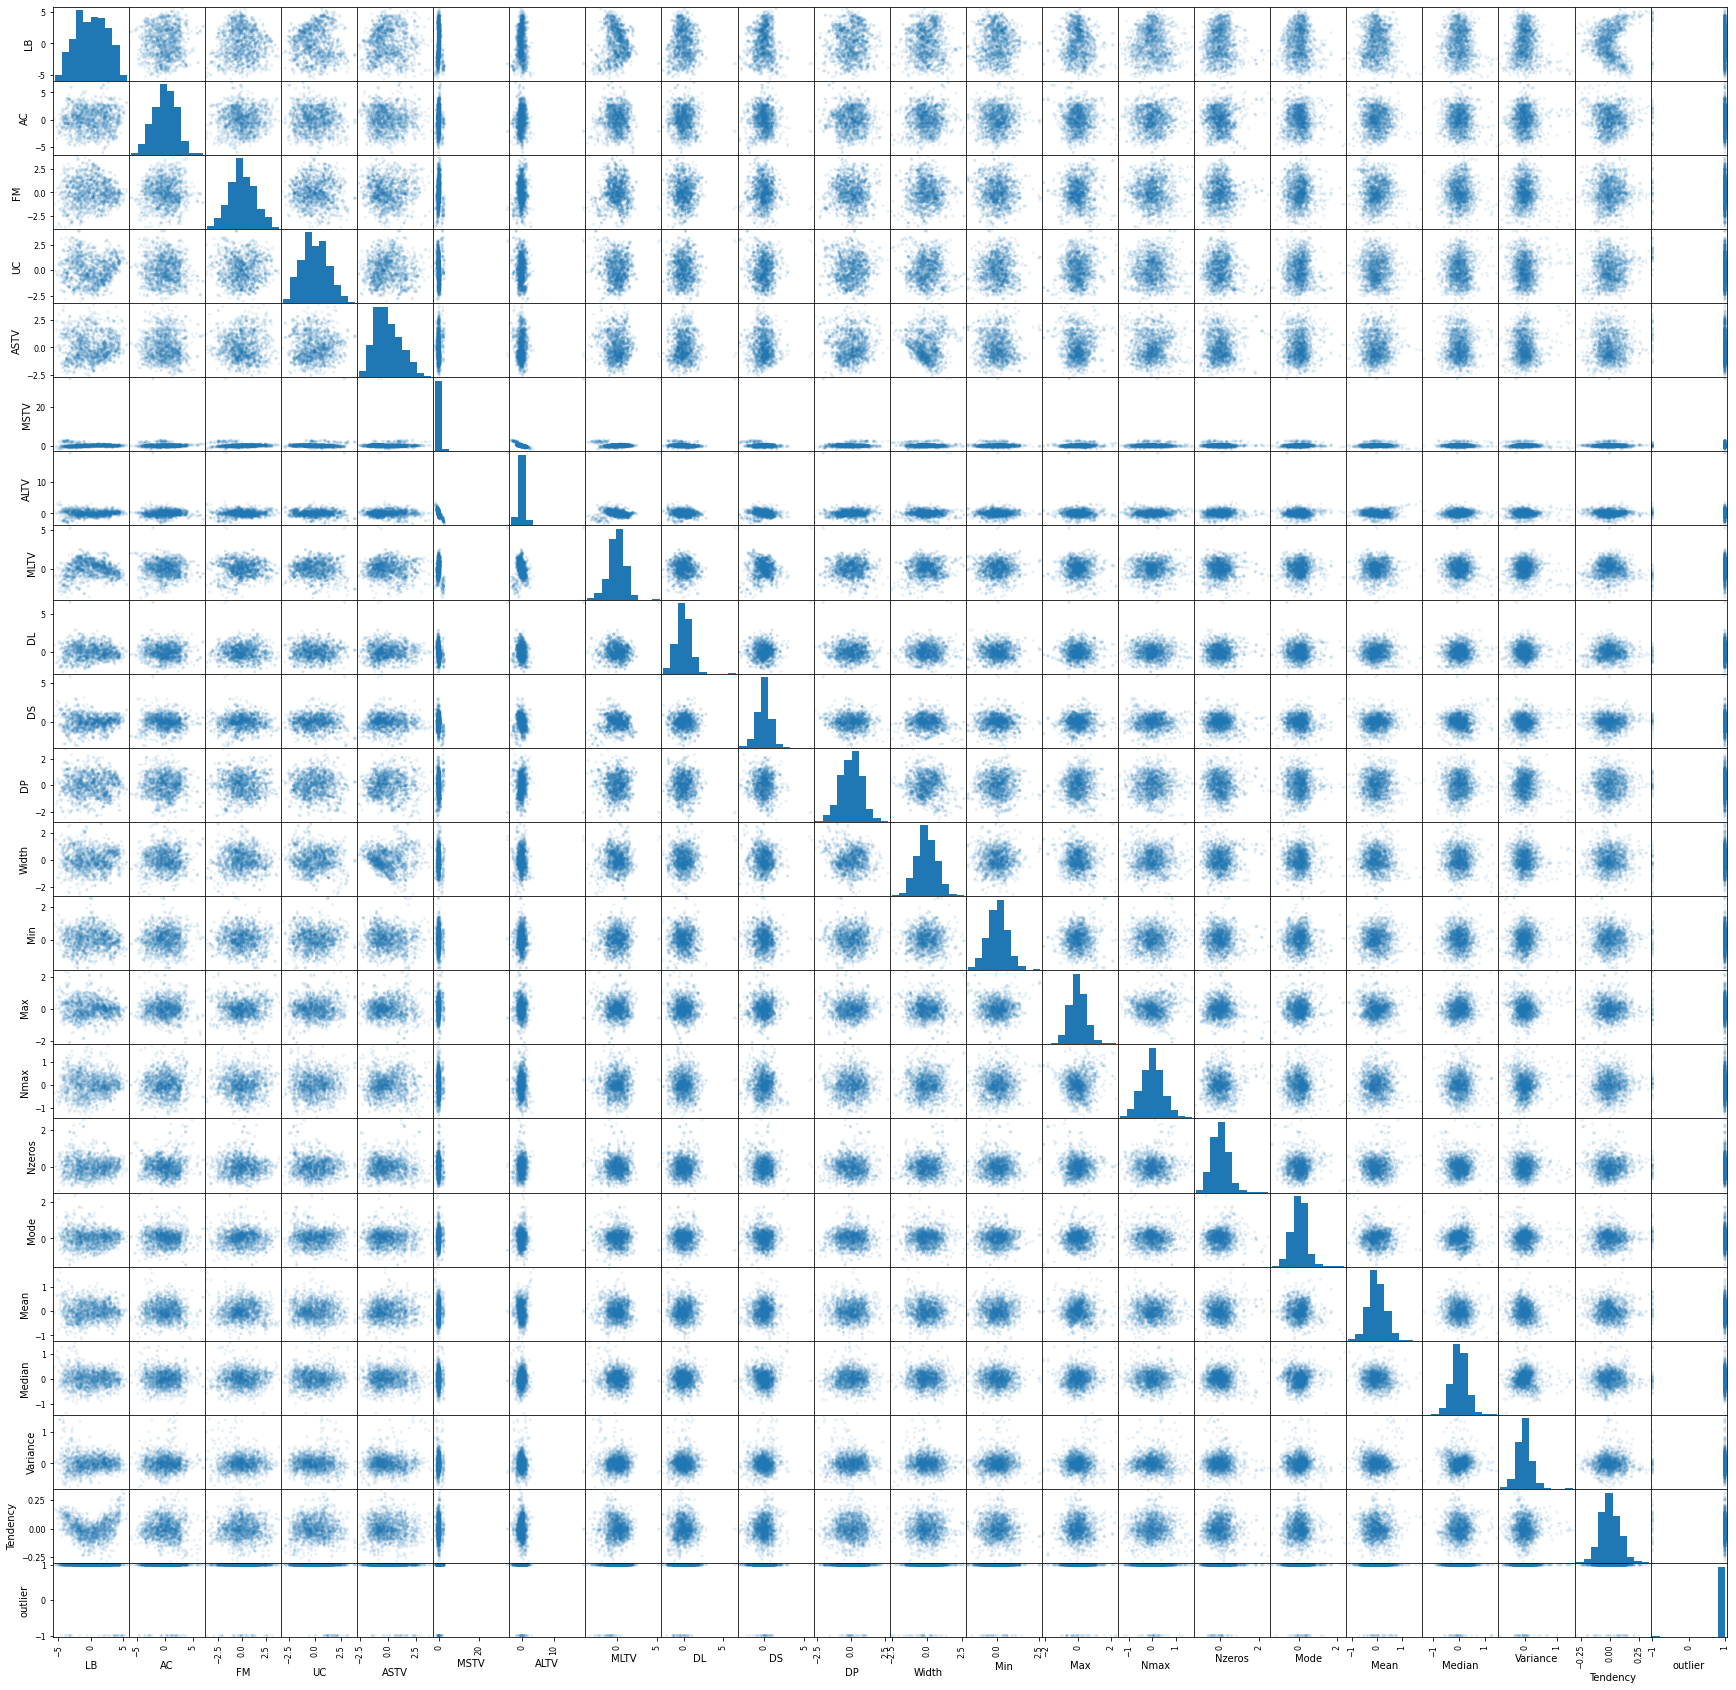

In [ ]:
scatter_matrix(df_trans.sample(frac = 0.1), alpha = 0.1, figsize = (30, 30), diagonal = 'hist');

Cool! Lots of elliptical blobs here. Maybe we can model the data as coming from a multivariate Gaussian? (I tried ICA and the results looked weird; the data typically clustered into two blobs that did not appear to be coincident with normal and anomalous cases.) 

Perhaps UMAP could be useful for outlier detection? Let's try!

### Outlier detection with UMAP

(Following the example [here](https://umap-learn.readthedocs.io/en/latest/outliers.html).)

In [ ]:
! pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import umap

mapper = umap.UMAP(set_op_mix_ratio=0.25).fit(df.drop(columns = "outlier"))

In [ ]:
df_umap = pd.DataFrame(mapper.embedding_, columns=["X1", "X2"])
df_umap["outlier"] = df["outlier"]
df_umap["y"] = df_umap["outlier"].astype(str)
df_umap.head()

X1         X2  outlier   y
0  -3.831201  -0.512989       -1  -1
1  14.134995  11.352165       -1  -1
2   3.399867   0.641153       -1  -1
3   2.181784   7.106334       -1  -1
4  -3.900244  -0.368996       -1  -1

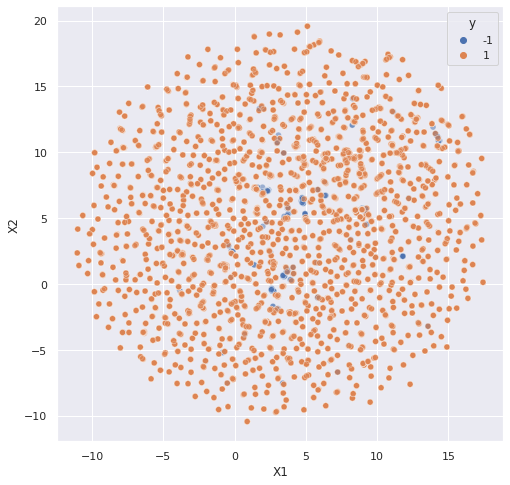

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(8, 8)}) # Why's the default size so small?

sns.scatterplot(data = df_umap, x = "X1", y = "X2", hue = "y", alpha = 0.5);

This doesn't look promising; the region in the lower dimensionality space occupied by the outliers overlaps with that occupied the normal cases. This is true irrespective of whether the data is transformed using the aforementioned preprocessing steps or not. I anticipate that outlier detection will be a very difficult.

## Mahalanobis rule

According to various sources found online, the squared Mahalanobis distance follows a $\chi^2$ Distribution with $n$ degrees of freedom, where $n$ is the number of features in our design matrix.

**Q: Is this correct? There is conflicting information available, and I was unable to find a canonical source. I encountered several pages online that claim the the Mahalanois distance, and not its square, follows a $\chi^2$ distribution. Which one is it?**

**Q: What is the degrees of freedom? Once again, online sources seem to be confused about this. Depending on who you ask, it's either equal to the number of features in the design matrix, or one less than that. Which one is it?**

In [ ]:
dof = df.drop(columns = "outlier").shape[1]
dof

21

In [ ]:
from sklearn.covariance import MinCovDet
from scipy.stats import chi2

cov = MinCovDet(random_state=0).fit(df.drop(columns = "outlier"))
Dsqr = cov.mahalanobis(df.drop(columns = "outlier"))

sig = 0.01 # Specified significance level, alpha

# Calculate p-value for each mahalanobis distance
p_vals = 1 - chi2.cdf(Dsqr, dof)
Mahalanobis_pred = np.where(p_vals < sig, -1, 1)
chi2.ppf((1 - sig), df = dof) # Critical region

38.93217268351607

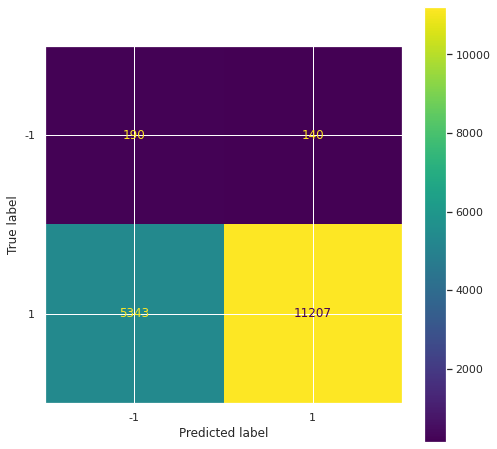

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(df["outlier"], Mahalanobis_pred);

In [ ]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(df["outlier"], Mahalanobis_pred))

              precision    recall  f1-score   support

          -1       0.03      0.58      0.06       330
           1       0.99      0.68      0.80     16550

    accuracy                           0.68     16880
   macro avg       0.51      0.63      0.43     16880
weighted avg       0.97      0.68      0.79     16880



In [ ]:
f1_score(df["outlier"], Mahalanobis_pred, pos_label = -1)

0.06481323554494287

The performance of the outlier detection method using Mahanobis distance is very poor.

Try again, with transformed features:

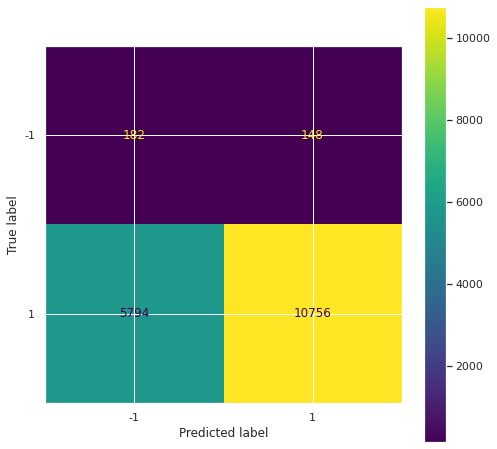

In [ ]:
cov = MinCovDet(random_state=0).fit(df_trans.drop(columns = "outlier"))
Dsqr = cov.mahalanobis(df_trans.drop(columns = "outlier"))

# Calculate p-value for each mahalanobis distance
p_vals = 1 - chi2.cdf(Dsqr, dof)
Mahalanobis_pred = np.where(p_vals < sig, -1, 1)
ConfusionMatrixDisplay.from_predictions(df_trans["outlier"], Mahalanobis_pred);

In [ ]:
print(classification_report(df_trans["outlier"], Mahalanobis_pred))

              precision    recall  f1-score   support

          -1       0.03      0.55      0.06       330
           1       0.99      0.65      0.78     16550

    accuracy                           0.65     16880
   macro avg       0.51      0.60      0.42     16880
weighted avg       0.97      0.65      0.77     16880



In [ ]:
f1_score(df_trans["outlier"], Mahalanobis_pred, pos_label = -1)

0.05772280367903584

It seems that transforming the data made the results slightly worse. 🙁

I want to be able to compare classifiers on an equal footing, so I'll create a custom Mahalanobis classifier so that I can use it with the same fitting infrastructure that I'll use later with other classifiers that I'll try:

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import numpy as np

class MahalanobisClassifier(BaseEstimator, ClassifierMixin):
  """
  Custom classifier for novelty detection using Mahalanobis distance
  """
  def __init__(self, alpha = 0.01):
    self.alpha = alpha
    self.cov = MinCovDet(random_state=0)

  def fit(self, X, y=None):
    self.cov.fit(X)
    
  def predict(self, X, y=None):
    Dsqr = self.cov.mahalanobis(X)
    dof = X.shape[1]
    p_vals = 1 - chi2.cdf(Dsqr, dof)
    preds = np.where(p_vals < self.alpha, 1, 0)
    return preds
    
  def predict_proba(self, X, y=None):
    Dsqr = self.cov.mahalanobis(X)
    dof = X.shape[1]
    probs = chi2.cdf(Dsqr, dof)
    return probs

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

mahal = Pipeline([
    ('powertransformer', PowerTransformer(standardize = True)),
    ('standardscaler', StandardScaler()),
    ('pca', PCA()),
    ('mahalanobisclassifier', MahalanobisClassifier(alpha = 0.01))
    ])
mahal

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('mahalanobisclassifier', MahalanobisClassifier())])

Let's test it without doing any hyperparameter tuning:

In [ ]:
data = df.drop(columns = "outlier")
# For consistency with other classifiers that I'll use later, recode target values:
target = df["outlier"].replace([1, -1], [0, 1])

clf = mahal.fit(data, target)

In [ ]:
preds = clf.predict(data)
preds

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
f1_score(target, preds, pos_label = 1)

0.053936348408710214

OK, that appears to work. Let's choose a performance metric to be used for all the following models:

In [ ]:
metric = "f1"


The parameter that we can tune is the significance level $\alpha$; let's do that:

In [ ]:
from scipy.stats import uniform, loguniform

mahal_param_grid = {
    'mahalanobisclassifier__alpha': np.logspace(-6, -1, num=6),
    }

rng = np.random.RandomState(42)

# Declare the inner and outer cross-validation strategies
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng)
# Number of guesses we'll make during random grid search:
tries = 25

# Inner cross-validation for parameter search
mahal_model_search = GridSearchCV(
    mahal,
    scoring = metric, 
    param_grid = mahal_param_grid, 
    cv = inner_cv, 
    verbose = 5,
    n_jobs = -1,
)

Let's see what the best $\alpha$ is:

In [ ]:
mahal_model_search.fit(data, target)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3,
        random_state=RandomState(MT19937) at 0x7F27E67258D0, shuffle=True),
             estimator=Pipeline(steps=[('powertransformer', PowerTransformer()),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('mahalanobisclassifier',
                                        MahalanobisClassifier())]),
             n_jobs=-1,
             param_grid={'mahalanobisclassifier__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])},
             scoring='f1', verbose=5)

In [ ]:
print(f"The best parameters found are: {mahal_model_search.best_params_}")

The best parameters found are: {'mahalanobisclassifier__alpha': 1e-05}


We perform nested CV with an outer validation loop to compute the test score:

In [ ]:
# Outer cross-validation to compute the test score
mahal_test_score = cross_val_score(mahal_model_search, data, target, scoring = metric, cv = outer_cv, n_jobs = -1, verbose = 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


In [ ]:
print(f"The mean score using nested cross-validation is: "
      f"{mahal_test_score.mean():.3f} ± {mahal_test_score.std():.3f}")

The mean score using nested cross-validation is: 0.067 ± 0.005


That's crap performance. 😒

## Supervised models

Logistic regression, SVM and KNN:

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

rng = np.random.RandomState(42)

lr = make_pipeline(pt, scaler, pca, LogisticRegression(random_state = rng, n_jobs = -1))
lr

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1,
                                    random_state=RandomState(MT19937) at 0x7F27E6725270))])

In [ ]:
lr_param_distributions = {
    'logisticregression__C': loguniform(1e-6, 1e3),
    'logisticregression__l1_ratio': uniform(0, 1),
}

# Inner cross-validation for parameter search
lr_model_search = RandomizedSearchCV(
    lr,
    scoring = metric, 
    param_distributions = lr_param_distributions, 
    n_iter = tries,
    cv = inner_cv, 
    verbose = 5,
    n_jobs = -1,
)

In [ ]:
lr_model_search.fit(data, target)
print(f"The best parameters found are: {lr_model_search.best_params_}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best parameters found are: {'logisticregression__C': 358.7599366681679, 'logisticregression__l1_ratio': 0.3190297981471073}


In [ ]:
# Outer cross-validation to compute the test score
lr_test_score = cross_val_score(lr_model_search, data, target, scoring = metric, cv = outer_cv, n_jobs = -1, verbose = 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


In [ ]:
print(f"The mean score using nested cross-validation is: "
      f"{lr_test_score.mean():.3f} ± {lr_test_score.std():.3f}")

The mean score using nested cross-validation is: 0.498 ± 0.053


### SVM

In [ ]:
from sklearn.svm import SVC

rng = np.random.RandomState(42)

svc = make_pipeline(pt, scaler, pca, SVC(random_state = rng))
svc

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('svc',
                 SVC(random_state=RandomState(MT19937) at 0x7F27E601C8D0))])

In [ ]:
svc_param_distributions = {
    'svc__C': loguniform(1e-2, 1e2),
    'svc__gamma': loguniform(1e-4, 1e1),
}

# Inner cross-validation for parameter search
svc_model_search = RandomizedSearchCV(
    svc,
    scoring = metric, 
    param_distributions = svc_param_distributions, 
    n_iter = tries,
    cv = inner_cv, 
    verbose = 5,
    n_jobs = -1,
)

In [ ]:
svc_model_search.fit(data, target)
print(f"The best parameters found are: {svc_model_search.best_params_}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best parameters found are: {'svc__C': 19.496898353913593, 'svc__gamma': 0.06377197024670293}


In [ ]:
# Outer cross-validation to compute the test score
svc_test_score = cross_val_score(svc_model_search, data, target, scoring = metric, cv = outer_cv, n_jobs = -1, verbose = 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  7.0min finished


In [ ]:
print(f"The mean score using nested cross-validation is: "
      f"{svc_test_score.mean():.3f} ± {svc_test_score.std():.3f}")

The mean score using nested cross-validation is: 0.765 ± 0.085


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = make_pipeline(pt, scaler, pca, KNeighborsClassifier(n_jobs = -1))
knn

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
knn_param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 50, step = 5),
    }

rng = np.random.RandomState(42)

# Declare the inner and outer cross-validation strategies
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng)

# Inner cross-validation for parameter search
knn_model_search = GridSearchCV(
    knn,
    scoring = metric, 
    param_grid = knn_param_grid, 
    cv = inner_cv, 
    verbose = 5,
    n_jobs = -1,
)

In [ ]:
knn_model_search.fit(data, target)
print(f"The best parameters found are: {knn_model_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
The best parameters found are: {'kneighborsclassifier__n_neighbors': 1}


In [ ]:
# Outer cross-validation to compute the test score
knn_test_score = cross_val_score(knn_model_search, data, target, scoring = metric, cv = outer_cv, n_jobs = -1, verbose = 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished


In [ ]:
print(f"The mean score using nested cross-validation is: "
      f"{knn_test_score.mean():.3f} ± {knn_test_score.std():.3f}")

The mean score using nested cross-validation is: 0.855 ± 0.005


## Unsupervised models — with hyperparameter tuning

### One-class SVM

In [ ]:
# One-class SVM and Isolation Forest label outliers as -1, else 1:
target = df["outlier"]
np.unique(target)

array([-1,  1])

It appears that I'm going to need to make my own scoring function to return the f1 score separately, because otherwise I get errors from **sklearn** because we're doing unsupervised learning and we need to fiddle with the scoring functions a little bit:

In [ ]:
from sklearn.metrics import f1_score, make_scorer

def custom_scoring_function(y_true, y_pred):
  """Returns the f1 score for the outliers only"""
  return f1_score(y_true, y_pred, average = None)[0]

custom_f1_scorer = make_scorer(custom_scoring_function, greater_is_better = True)

In [ ]:
from sklearn.svm import OneClassSVM

rng = np.random.RandomState(42)

ocsvm = make_pipeline(pt, scaler, pca, OneClassSVM())
ocsvm

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('oneclasssvm', OneClassSVM())])

In [ ]:
ocsvm_param_distributions = {
    'oneclasssvm__gamma': loguniform(1e-4, 1e1),
    'oneclasssvm__nu': uniform(0, 1),
}

# Inner cross-validation for parameter search
ocsvm_model_search = RandomizedSearchCV(
    ocsvm,
    scoring = custom_f1_scorer, 
    param_distributions = ocsvm_param_distributions, 
    n_iter = tries,
    cv = inner_cv, 
    verbose = 5,
    n_jobs = -1,
)

In [ ]:
ocsvm_model_search.fit(data, target)
print(f"The best parameters found are: {ocsvm_model_search.best_params_}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best parameters found are: {'oneclasssvm__gamma': 0.030649373440733874, 'oneclasssvm__nu': 0.025157414782582155}


In [ ]:
ocsvm_model_search.cv_results_

{'mean_fit_time': array([ 2.80552999, 10.7549626 , 15.27863399, 16.03194213,  5.5636855 ,
        39.07700404, 41.761415  , 18.7317423 ,  3.34079409, 14.90295982,
        21.44078072,  1.51073821, 50.81818819, 15.06382028, 15.1044027 ,
        14.84912666, 47.47841326, 16.71738227, 15.32415326, 15.07663194,
        11.36065571, 12.0169421 , 26.82001893, 16.24651106, 15.30397669]),
 'mean_score_time': array([ 0.80644409,  3.32208459,  5.71863055,  8.03537154,  1.6988852 ,
         6.79158815,  8.15197929,  4.59789141,  0.98235234, 11.24084051,
         5.8901786 ,  0.29418151,  8.41668669,  5.2550923 ,  5.08811625,
         9.95244082,  8.91157818,  5.72975643,  7.02612789,  4.9432385 ,
         3.27733278,  3.71508582,  4.9604636 ,  7.98129114,  5.52194818]),
 'mean_test_score': array([0.1894878 , 0.09102427, 0.06011715, 0.04635167, 0.11871778,
        0.05065761, 0.04297789, 0.0703491 , 0.1778245 , 0.03841677,
        0.05975501, 0.23357144, 0.04326669, 0.06947456, 0.06793908,
       

In [ ]:
ocsvm_model_search.best_score_ # Just a sanity check, not a reliable measure of performance!

0.2335714385989327

In [ ]:
# Outer cross-validation to compute the test score
ocsvm_test_score = cross_val_score(ocsvm_model_search, data, target, scoring = custom_f1_scorer, cv = outer_cv, n_jobs = -1, verbose = 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 16.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 16.9min finished


In [ ]:
print(f"The mean score using nested cross-validation is: "
      f"{ocsvm_test_score.mean():.3f} ± {ocsvm_test_score.std():.3f}")

The mean score using nested cross-validation is: 0.186 ± 0.036


### Isolation forest

In [ ]:
from sklearn.ensemble import IsolationForest

iforest = np.random.RandomState(42)

iforest = make_pipeline(pt, scaler, pca, IsolationForest())
iforest

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('isolationforest', IsolationForest())])

I treated the prevalence of anomalies in the data to be another hyperparameter to be learned, rather than specifying it, because using knowledge gained from the whole dataset is kinda cheating.

In [ ]:
class loguniform_int:
    """
    Integer valued version of the log-uniform distribution
    https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_randomized_search.html
    """
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


iforest_param_distributions = {
    'isolationforest__contamination': loguniform(1e-4, 0.5),
    'isolationforest__max_features': loguniform_int(1, data.shape[1]),
}

# Inner cross-validation for parameter search
iforest_model_search = RandomizedSearchCV(
    iforest,
    scoring = custom_f1_scorer, 
    param_distributions = iforest_param_distributions, 
    n_iter = tries,
    cv = inner_cv, 
    verbose = 5,
    n_jobs = -1,
)

In [ ]:
iforest_model_search.fit(data, target)
print(f"The best parameters found are: {iforest_model_search.best_params_}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best parameters found are: {'isolationforest__contamination': 0.02410143409359523, 'isolationforest__max_features': 18}


In [ ]:
iforest_model_search.cv_results_

{'mean_fit_time': array([1.77317341, 1.88265212, 1.68538531, 1.81235965, 1.77464596,
        1.75647028, 1.688742  , 1.87683296, 1.80223234, 1.95448867,
        1.84505876, 1.69984253, 2.43235493, 2.56378977, 1.72259951,
        1.89143689, 1.87003636, 1.82794086, 2.1619188 , 2.05680911,
        1.83083073, 1.99000351, 1.9350245 , 1.80273207, 1.59442051]),
 'mean_score_time': array([0.37732339, 0.42181134, 0.38828437, 0.39463131, 0.3756241 ,
        0.46769381, 0.348418  , 0.42732708, 0.39859525, 0.42855446,
        0.3956097 , 0.35809898, 0.60779691, 0.48020188, 0.35722375,
        0.4166197 , 0.39841692, 0.38729191, 0.48884948, 0.47106433,
        0.41384466, 0.4539535 , 0.44444323, 0.38932872, 0.34495354]),
 'mean_test_score': array([0.02370512, 0.136517  , 0.13147298, 0.03469678, 0.06694909,
        0.08706741, 0.09843582, 0.02944862, 0.06441863, 0.07233694,
        0.07914821, 0.05591078, 0.13323671, 0.08341981, 0.07955725,
        0.06602187, 0.04673547, 0.0931473 , 0.05099971, 0

In [ ]:
iforest_model_search.best_score_ # Just a sanity check, not a reliable measure of performance!

0.15195498024638324

In [ ]:
# Outer cross-validation to compute the test score
iforest_test_score = cross_val_score(iforest_model_search, data, target, scoring = custom_f1_scorer, cv = outer_cv, n_jobs = -1, verbose = 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min finished


In [ ]:
print(f"The mean score using nested cross-validation is: "
      f"{iforest_test_score.mean():.3f} ± {iforest_test_score.std():.3f}")

The mean score using nested cross-validation is: 0.177 ± 0.058


## Chosen metric

I chose the $F_1$ metric, the harmonic mean of the precision and recall, because it is better suited to problems (like this one) with imbalanced classes than accuracy.

In [ ]:
all_scores = {
    "Mahalanobis classifier": mahal_test_score,
    "ElasticNet (regularised logistic regression)": lr_test_score,
    "Support Vector Machine (SVM)": svc_test_score,
    "K-Nearest Neighbours": knn_test_score,
    "One-class SVM": ocsvm_test_score,
    "Isolation Forest": iforest_test_score
}

all_scores = pd.DataFrame(all_scores)

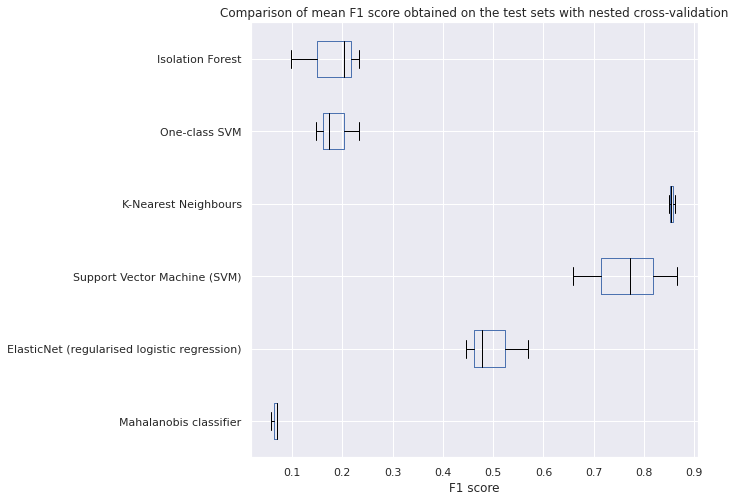

In [ ]:
import matplotlib.pyplot as plt

colour = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color = colour, vert=False)
plt.xlabel("F1 score")
_ = plt.title("Comparison of mean F1 score obtained on the test sets with nested cross-validation")

### Results  
 
 * Of all the supervised methods tried, KNN was the best.
 * Of the unsupervised methods tried, Isolation Forest was the best, although One-Class SVM had quite similar performance.
 * The best method overall was KNN.

---
## Extra material

(Things I tried that didn't work as I expected)

I wanted to fit the parameters of the data transformations on the normal case and then transform all the data using those parameters. That is, I wanted to omit the outliers when learning the parameters for the transformations. I didn't want weird outliers to pull the learned parameters away from the values they would have if outliers were absent.

Unfortunately, there doesn't appear to be an easy way to subsample the data in a pipeline with **sklearn**, so I used a related package to do this:

In [ ]:
! pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt

def plot_scatter(X, y, title, alpha = 1):
    """Function to plot some data as a scatter plot."""
    plt.figure()
    plt.scatter(X[y == -1, 0], X[y == -1, 1], label="Class -1", alpha = alpha)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class 1", alpha = alpha)
    plt.legend()
    plt.title(title)

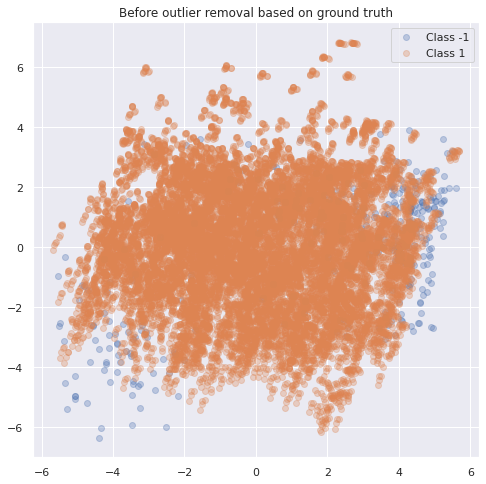

In [ ]:
X_dummy = df_trans.iloc[:, 0:2].to_numpy()
y_dummy = df_trans.iloc[:, -1].to_numpy()

plot_scatter(X_dummy, y_dummy, "Before outlier removal based on ground truth", alpha = 0.3)

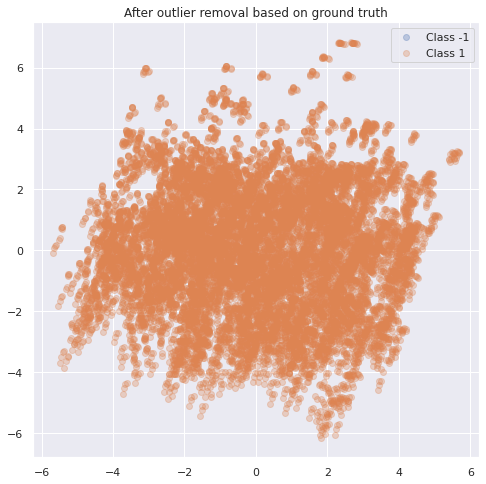

In [ ]:
from imblearn import FunctionSampler

def outlier_rejection(X, y):
    """This will be our function used to resample our dataset."""
    return X[y == 1], y[y == 1]


reject_sampler = FunctionSampler(func=outlier_rejection)
X_inliers, y_inliers = reject_sampler.fit_resample(X_dummy, y_dummy)
plot_scatter(X_inliers, y_inliers, "After outlier removal based on ground truth", alpha = 0.3)

The plot above demonstrates the `outlier_rejection` function is able to subsample the data to remove the outliers.

I tried building a pipeline with this filter. Of course, now I can only use unsupervised methods:

In [ ]:
from sklearn.svm import OneClassSVM
from imblearn.pipeline import make_pipeline

pipe = make_pipeline(
    FunctionSampler(func=outlier_rejection),
    pt,
    scaler,
    pca,
    OneClassSVM(gamma='auto'),
    # LogisticRegression(solver="lbfgs", multi_class="auto", random_state=rng),
)
pipe

Pipeline(steps=[('functionsampler',
                 FunctionSampler(func=<function outlier_rejection at 0x7f27e52033b0>)),
                ('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('oneclasssvm', OneClassSVM(gamma='auto'))])

I did a simple train-test split with a third of the data oleft out for testing:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = "outlier"), y,
    test_size=0.33, random_state=rng)

y_pred = pipe.fit(X_train, y_train).predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.04      0.94      0.07       225
           1       1.00      0.50      0.67     11084

    accuracy                           0.51     11309
   macro avg       0.52      0.72      0.37     11309
weighted avg       0.98      0.51      0.65     11309



The performance evaluated on the training data is very underwhelming. This doesn't bode well for the performance we can expect on data that was unseen during training:

In [ ]:
y_pred = pipe.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

# clf = LogisticRegression(solver="lbfgs", multi_class="auto", random_state=rng)
# y_pred = clf.fit(X_train, y_train).predict(X_test)
# print(classification_report(y_test, y_pred))

# plt.show()

              precision    recall  f1-score   support

          -1       0.03      0.90      0.07       105
           1       1.00      0.51      0.67      5466

    accuracy                           0.52      5571
   macro avg       0.51      0.70      0.37      5571
weighted avg       0.98      0.52      0.66      5571



Yup, that's very poor performance. This strategy doesn't seem to be panning-out. Let's try with Isolation Forest:

In [ ]:
contamination = df["outlier"].value_counts().iloc[1] / df.shape[0]
contamination

0.019549763033175356

It's kind of cheating to learn the contamination from the data. There's some information leakage happening here. I'm just going to ignore that and assume that we have some expert knowledge about the prevalence of fetal heart problems that enables us to quantify our *prior degree of belief* that a patient selected at random will have an abnormal cardiotocography.

Here's the model:

In [ ]:
from sklearn.ensemble import IsolationForest

pipe = make_pipeline(
    FunctionSampler(func=outlier_rejection),
    pt,
    scaler,
    pca,
    IsolationForest(max_samples = 100, contamination=contamination, random_state=rng),
    # LogisticRegression(solver="lbfgs", multi_class="auto", random_state=rng),
)
pipe

Pipeline(steps=[('functionsampler',
                 FunctionSampler(func=<function outlier_rejection at 0x7f27e52033b0>)),
                ('powertransformer', PowerTransformer()),
                ('standardscaler', StandardScaler()), ('pca', PCA()),
                ('isolationforest',
                 IsolationForest(contamination=0.019549763033175356,
                                 max_samples=100,
                                 random_state=RandomState(MT19937) at 0x7F27E601CAF0))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = "outlier"), y,
    test_size=0.33, random_state=rng)

y_pred = pipe.fit(X_train, y_train).predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.17      0.21      0.19       223
           1       0.98      0.98      0.98     11086

    accuracy                           0.97     11309
   macro avg       0.58      0.59      0.59     11309
weighted avg       0.97      0.97      0.97     11309



In [ ]:
y_pred = pipe.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.13      0.15      0.14       107
           1       0.98      0.98      0.98      5464

    accuracy                           0.96      5571
   macro avg       0.56      0.56      0.56      5571
weighted avg       0.97      0.96      0.97      5571



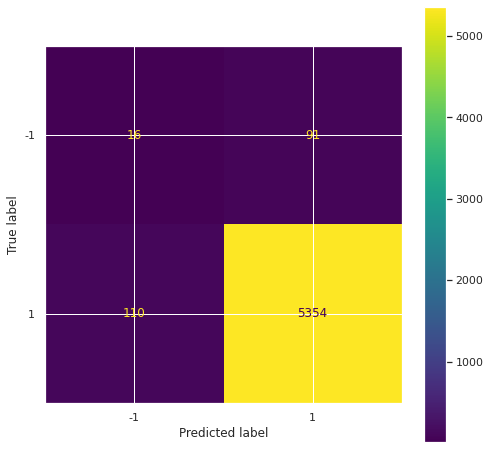

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

That's not significantly better performance than I got with Isolation Forest previously without any special treatment in the way the data transformations were learned and applied. This doesn't appear to be a winning strategy.